In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import boto3
from io import BytesIO
# from s3fs.core import S3FileSystem
import matplotlib.pyplot as plt
from distribution.stable_nromal import StableNormal
from distribution.mixture_same_family import ReparametrizedMixtureSameFamily

In [56]:
s3 = boto3.resource('s3')

In [57]:
class round_bp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.input = input
        return torch.round(input)

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.clone()
        return grad_input

class float_bp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.input = input
        return float(input)

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.clone()
        return grad_input

In [58]:
# load from AWS
data_obj = s3.Bucket("compwell-databucket").Object("processed_DA/ptbxl/100hz/test_dict_12lead.npy")
data_all = np.load(BytesIO(data_obj.get()['Body'].read()), allow_pickle=True).item()
data = torch.Tensor(data_all['ECG_signal'][:2]).permute(0,2,1)

In [ ]:
# load from local path
data_all = np.load('/rdf/data/physionet.org/processed_DA/ptbxl/100hz/test_dict_12lead.npy', allow_pickle=True).item()
data = torch.Tensor(data_all['ECG_signal'][0], requires_grad=True).permute(1,0).unsqueeze(0)

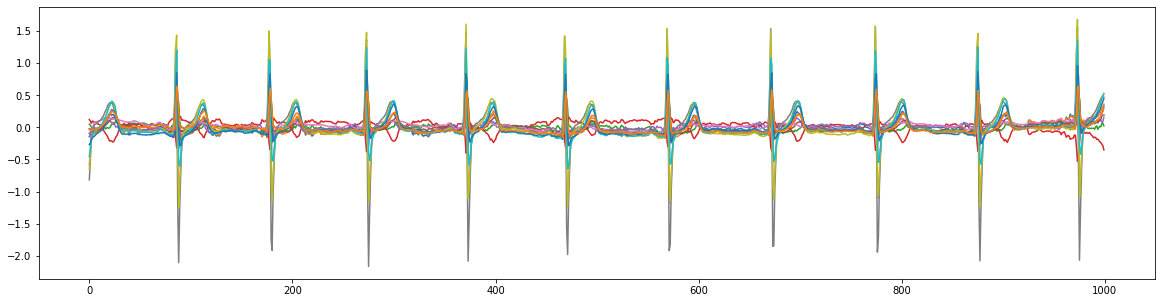

In [59]:
plt.figure(figsize=(20,5))
plt.plot(data[0].T)

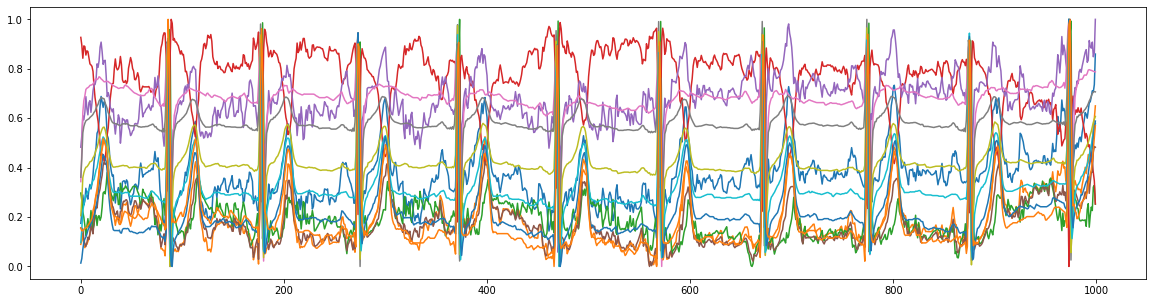

In [11]:
data = torch.Tensor(data_all['ECG_signal'][:2]).permute(0,2,1)
data -= data.min(2, keepdim=True)[0]
data /= data.max(2, keepdim=True)[0]
plt.figure(figsize=(20,5))
plt.plot(data[0].T)

In [12]:
data.min(2, keepdim=True)[0]

tensor([[[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]])

In [44]:
probabilities_dist = torch.distributions.RelaxedBernoulli(0.1, 0.1)
sample_probabilities = probabilities_dist.rsample()
print(sample_probabilities.grad_fn)

None


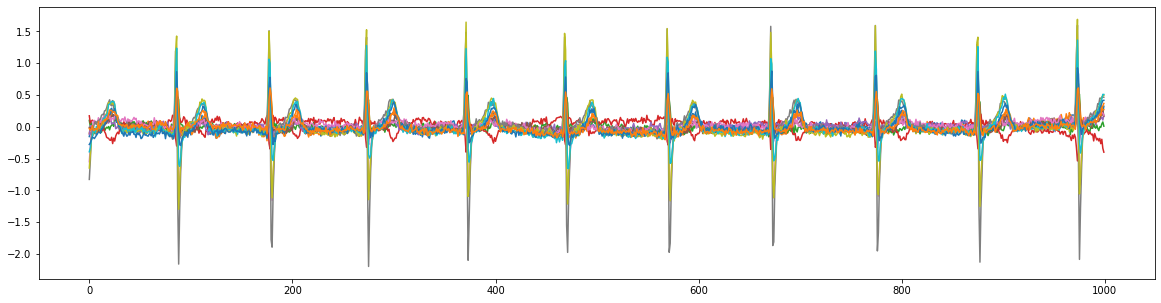

In [60]:
## Jittering
def jitter(x, sigma):
    m = torch.distributions.normal.Normal(loc=0, scale=sigma[0])
    noise = m.rsample(sample_shape=x.size())
    noisy_x = x + noise
    return noisy_x

jitter_sigma = nn.Parameter(0.03 * torch.ones(1), requires_grad=True)
jitter_x = jitter(data, jitter_sigma)
print(jitter_x.grad_fn)
plt.figure(figsize=(20,5))
plt.plot(jitter_x.detach().numpy()[0].T)

tensor([[0.9344, 1.0062, 0.9891, 0.9317, 1.0394, 0.9996, 1.0187, 1.0474, 1.0010,
         0.9873, 1.0239, 1.0094],
        [0.9579, 0.9716, 1.0122, 0.9278, 1.0301, 0.9499, 0.9965, 1.0414, 0.9712,
         0.9410, 0.9853, 1.0178]], grad_fn=<AddBackward0>)
Parameter containing:
tensor([0.0300], requires_grad=True) <MulBackward0 object at 0x7f0878b4e310>


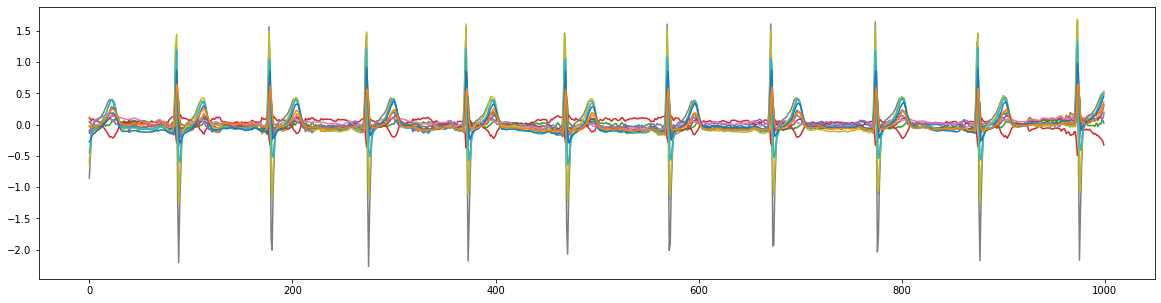

In [61]:
## Scaling
def scaling(x, sigma):
    m = torch.distributions.normal.Normal(loc=1, scale=sigma[0])
    factor = m.rsample(sample_shape=x.size()[:2])
    print(factor)
    output = x * factor.unsqueeze(-1)
    return output

scaling_sigma = nn.Parameter(0.03 * torch.ones(1), requires_grad=True)
scaling_x = scaling(data, scaling_sigma)
print(scaling_sigma, scaling_x.grad_fn)
plt.figure(figsize=(20,5))
plt.plot(scaling_x.detach().numpy()[0].T)

torch.Size([2, 12])


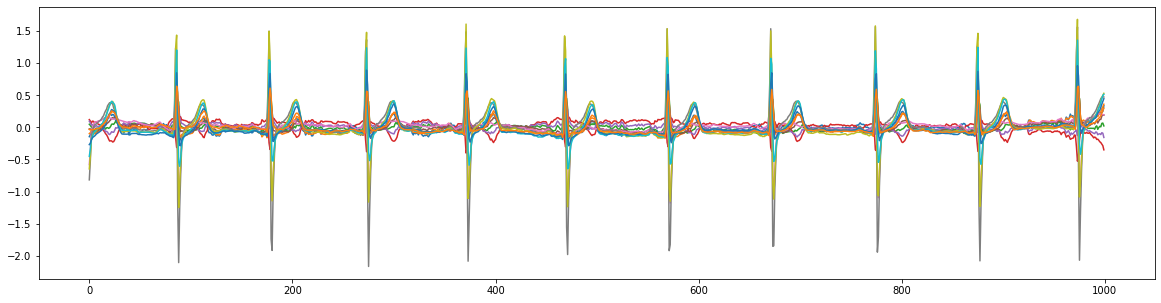

In [75]:
## Rotation
def rotation(x, probs, temperature=0.01):
    """
    x.shape = [batchsize, channel, features]
    """
    m = torch.distributions.relaxed_bernoulli.LogitRelaxedBernoulli(temperature, probs=probs)
    flip = m.rsample()
    flip = F.hardtanh(flip)
    output =  flip.view(x.size()[0], x.size()[1], 1) * x
    return output

rotation_prob = nn.Parameter((1 - 0.1) * torch.ones(data.size()[1]), requires_grad=True)
rotation_prob = rotation_prob.repeat(data.size()[0],1)
print(rotation_prob.shape)
rotation_x = rotation(data, rotation_prob)
print(rotation_x.grad_fn)
plt.figure(figsize=(20,5))
plt.plot(rotation_x.detach().numpy()[0].T)

/home/hy29/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


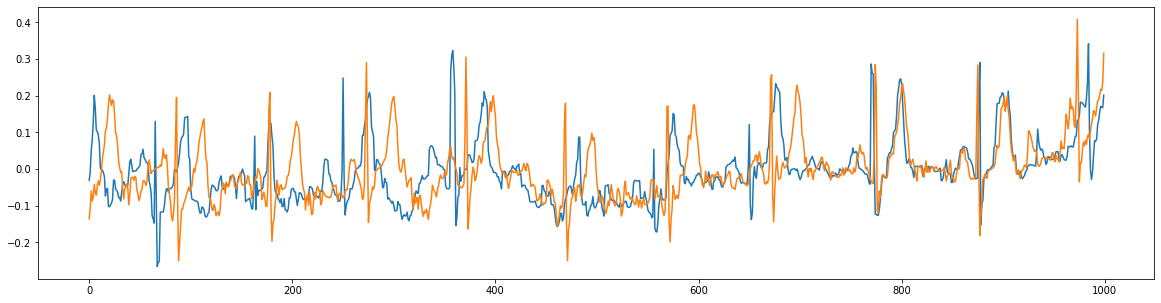

In [95]:
## Time distortion
## Time distortion
def time_distortion(x, mixture_weights, nromal_mean, nromal_sigma):
    mixture_cate = torch.distributions.Categorical(probs=F.softmax(mixture_weights))
    normal_dists = StableNormal(loc=nromal_mean, scale=nromal_sigma)
    mixture_normal = ReparametrizedMixtureSameFamily(mixture_distribution=mixture_cate,
                                                     component_distribution=normal_dists)
    mixture_norm_samples = mixture_normal.rsample(sample_shape=(x.size(0),x.size(2)))
    mixture_norm_samples = torch.tanh(mixture_norm_samples)
    # mixture_norm_samples = (mixture_norm_samples - mixture_norm_samples.min(1)[0]) / (mixture_norm_samples.max(1)[0] - mixture_norm_samples.min(1)[0])
    mixture_norm_samples, _ = torch.sort(mixture_norm_samples)

    x_hw = x.unsqueeze(2)
    grid_hw = mixture_norm_samples.unsqueeze(1)
    grid_hw = torch.cat([grid_hw, 0 * torch.ones_like(grid_hw)], dim=1).permute(0,2,1).unsqueeze(1)
    x_distorted = F.grid_sample(x_hw, grid_hw, align_corners=False).squeeze(-2)
    return x_distorted

mixture_weights = nn.Parameter(torch.ones(3), requires_grad=True)
nromal_mean = nn.Parameter(torch.Tensor([-0.5, 0.0, 0.5]), requires_grad=True)
nromal_sigma = nn.Parameter(torch.Tensor([0.7, 0.7, 0.7]), requires_grad=True)
timeDis_x = time_distortion(data, mixture_weights, nromal_mean, nromal_sigma)
print(timeDis_x.grad_fn)
plt.figure(figsize=(20,5))
plt.plot(timeDis_x[0,0].detach().numpy().T)
plt.plot(scaling_x.detach().numpy()[0,0].T)

Parameter containing:
tensor([5.], requires_grad=True) tensor([6.2651e-05])


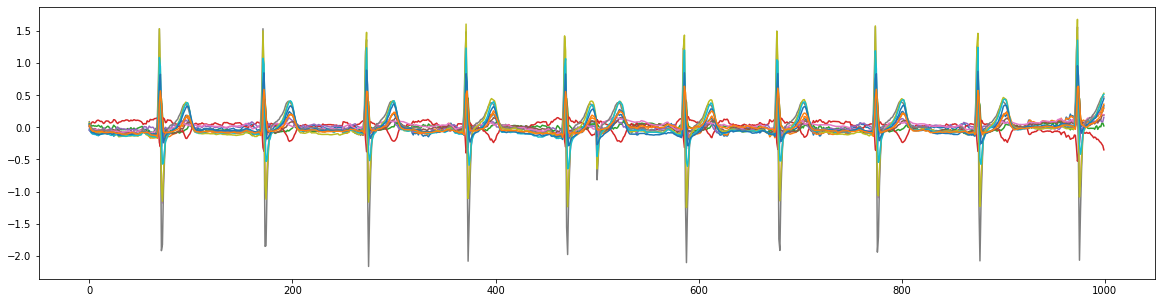

In [63]:
## Permutation
class permuteView(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, num_seg):
        splits = torch.split(x, torch.div(x.size(-1), int(num_seg), rounding_mode='trunc'), dim=-1)
        if x.size(-1) % num_seg == 0:
            permuted_order = torch.randperm(int(num_seg))
        else:
            permuted_order = torch.randperm(int(num_seg) + 1)
        ctx.save_for_backward(num_seg, permuted_order)
        splits_permuted = []
        for idx in permuted_order.detach().numpy():
            splits_permuted.append(splits[idx])
        output = torch.cat(splits_permuted, dim=-1)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        num_seg,permuted_order, = ctx.saved_tensors
        splits = torch.split(grad_output, torch.div(grad_output.size(-1), int(num_seg), rounding_mode='trunc'), dim=-1)
        splits_permuted = []
        for idx in permuted_order:
            splits_permuted.append(splits[idx])
        grad_output = torch.cat(splits_permuted, dim=-1)
        return grad_output, grad_output.mean().unsqueeze(0)

def permutation(x, max_segments):
    m_uniform = torch.distributions.uniform.Uniform(1, max_segments)
    num_segs_soft = m_uniform.rsample(x.size()[:1])
    num_segs = torch.round(num_segs_soft) - num_segs_soft.detach() + num_segs_soft
    permute_x = []
    for i, pat in enumerate(x):
        if num_segs[i] > 1:
            permute_view = permuteView.apply(pat.unsqueeze(0), num_segs[i])
        else:
            permute_view = pat
        permute_x.append(permute_view)
    return torch.cat(permute_x, dim=0)

permuation_seg = nn.Parameter(5 * torch.ones(1), requires_grad=True)
permuted_x = permutation(data, permuation_seg)
permuted_x.mean().backward()
print(permuation_seg, permuation_seg.grad)
plt.figure(figsize=(20,5))
plt.plot(permuted_x.detach().numpy()[0].T)

Parameter containing:
tensor([0.1000], requires_grad=True) tensor([0.0034])


/home/hy29/anaconda3/envs/general_dl/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


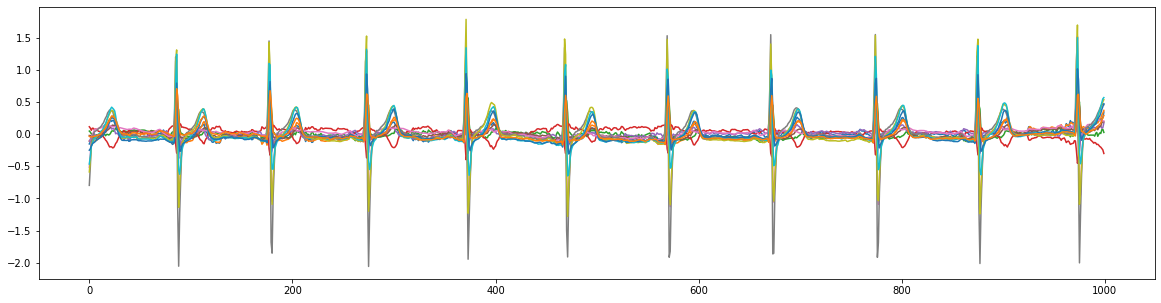

In [66]:
## Magnitude Warping
def magnitude_warp(x, sigma, knot=4):
    m = torch.distributions.normal.Normal(loc=1, scale=sigma[0])
    yy = m.rsample(sample_shape=(x.size(0), x.size(1), knot))
    wave = F.interpolate(yy, size=x.size(2), mode ='linear')
    return wave * x

magW_sigma = nn.Parameter(0.1 * torch.ones(1), requires_grad=True)
magW_x = magnitude_warp(data, magW_sigma)
magW_x.mean().backward()
print(magW_sigma, magW_sigma.grad)
plt.figure(figsize=(20,5))
plt.plot(magW_x[0].detach().numpy().T)

In [184]:


num_seg = nn.Parameter(5 * torch.ones(1), requires_grad=True)
test_permute = permute_view(data, num_seg)
test_permute.mean().backward()

tensor(8.3333e-05)


In [162]:
test_permute

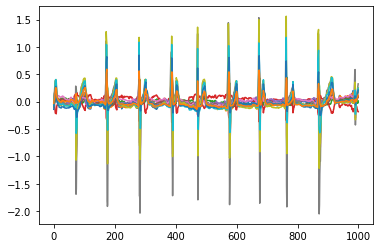

In [98]:
plt.plot(x_distorted[0].detach().numpy().T)

In [84]:
mixture_norm_samples

tensor([[-0.9860, -0.9854, -0.9783, -0.9735, -0.9682, -0.9656, -0.9581, -0.9570,
         -0.9533, -0.9514, -0.9512, -0.9487, -0.9476, -0.9304, -0.9301, -0.9278,
         -0.9257, -0.9247, -0.9239, -0.9238, -0.9234, -0.9228, -0.9222, -0.9206,
         -0.9114, -0.9111, -0.9087, -0.9079, -0.9060, -0.9000, -0.8993, -0.8991,
         -0.8980, -0.8962, -0.8934, -0.8924, -0.8880, -0.8869, -0.8859, -0.8837,
         -0.8802, -0.8799, -0.8797, -0.8772, -0.8763, -0.8745, -0.8720, -0.8690,
         -0.8644, -0.8608, -0.8584, -0.8556, -0.8550, -0.8541, -0.8530, -0.8527,
         -0.8524, -0.8520, -0.8475, -0.8471, -0.8457, -0.8443, -0.8431, -0.8400,
         -0.8394, -0.8364, -0.8361, -0.8330, -0.8323, -0.8320, -0.8305, -0.8270,
         -0.8252, -0.8249, -0.8229, -0.8214, -0.8209, -0.8187, -0.8172, -0.8165,
         -0.8097, -0.8097, -0.8021, -0.8009, -0.7981, -0.7973, -0.7953, -0.7916,
         -0.7881, -0.7880, -0.7860, -0.7857, -0.7854, -0.7840, -0.7817, -0.7816,
         -0.7807, -0.7783, -

In [99]:
x_distorted.mean().backward()
mixture_weights.grad

tensor([ 0.0406, -0.0250, -0.0156])

In [285]:
x = data
knot = 2
orig_steps = np.arange(x.shape[2])

random_warps = np.random.normal(loc=1.0, scale=0.2, size=(x.shape[0], x.shape[1], knot+2))
warp_steps = (np.ones((x.shape[1],1))*(np.linspace(0, x.shape[2]-1., num=knot+2)))
ret = np.zeros_like(x)
for i, pat in enumerate(x):
    time_warp = CubicSpline(warp_steps[:,1], warp_steps[:,1] * random_warps[i, 0])(orig_steps)
    scale = (x.shape[2]-1)/time_warp[-1]
    ret[i] = np.interp(orig_steps, np.clip(scale*time_warp, 0, x.shape[2]-1), pat).T
output =  ret

ValueError: operands could not be broadcast together with shapes (12,) (4,) 

In [286]:
random_warps[i, 0]

array([1.02022587, 0.66804056, 0.95860785, 0.95538015])

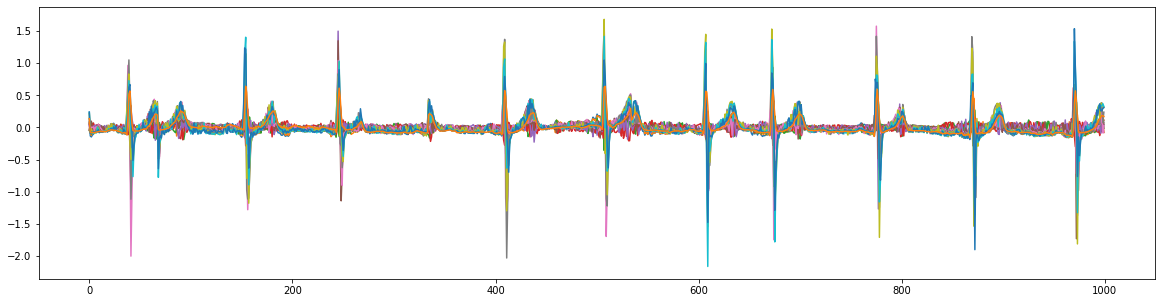

In [260]:
plt.figure(figsize=(20,5))
plt.plot(output[0].T)

In [148]:
test = torch.arange(9).unsqueeze(1).repeat(1, 10)
test

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
        [6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
        [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
        [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]])

In [151]:
test.size()

torch.Size([9, 10])

tensor(1.1277, grad_fn=<SelectBackward0>)
torch.Size([1, 12, 1127])
Parameter containing:
tensor([0.2000], requires_grad=True) None


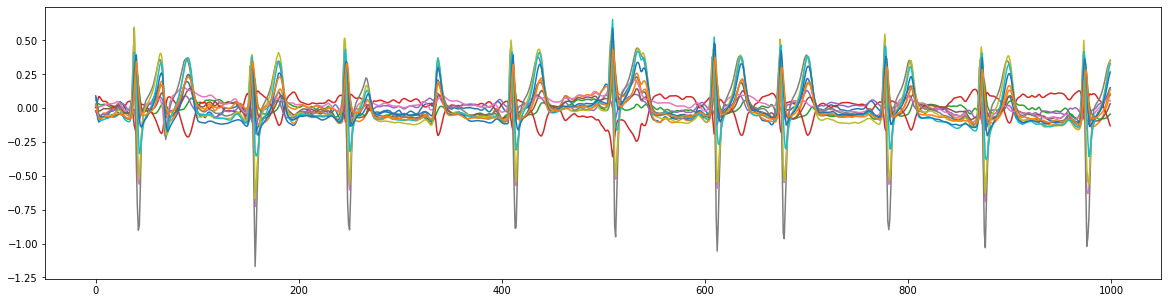

In [321]:
## Time Warping
def round_node(node, length):
    while length % node != 0:
        node -= 1
    return node

def time_warp(x, sigma, knot=8):
    node = round_node(knot, x.size(0))
    # segment_length = int(x.size(0) / node)
    m = torch.distributions.normal.Normal(loc=1, scale=sigma[0])
    timeW_random = m.rsample(sample_shape=(x.size(0), node))
    # timeW_random = round_bp(timeW_random)
    x_trunc = x.view(x.size(0), x.size(1), node, x.size(2) // node)
    for i in range(x.size(0)):
        pat = []
        for j in range(node):
            segment = x_trunc[i,:,j,:]
            print(timeW_random[i, j])
            segment_interpolate = F.interpolate(segment.unsqueeze(0), scale_factor=float_bp.apply(timeW_random[i, j]), mode='linear')
            print(segment_interpolate.size())
            pat.append(segment_interpolate)
        x[i] = F.interpolate(torch.cat(pat), size=x.size(2), mode='linear')
    return x

timeW_sigma = nn.Parameter(0.2 * torch.ones(1), requires_grad=True)
timeW_x = time_warp(data, timeW_sigma)
# timeW_x.mean().backward()
print(timeW_sigma, timeW_sigma.grad_fn)
plt.figure(figsize=(20,5))
plt.plot(timeW_x[0].detach().numpy().T)

In [20]:
# load from AWS (apnea_ECG)
data_obj = s3.Bucket("compwell-databucket").Object("processed_DA/sleep_apnea/sleep_apnea_test.csv")
data = pd.read_csv(BytesIO(data_obj.get()['Body'].read()), sep='\t', header=None)

In [22]:
ecg, labels = data.values[:, 1:], data.values[:,0]

In [48]:
ecg_sample = ecg[500]
ecg_sample = torch.Tensor(ecg_sample).unsqueeze(0).unsqueeze(0)
ecg_sample.shape

torch.Size([1, 1, 6000])

In [108]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def normalization(x):
    x -= x.min(2, keepdim=True)[0]
    x /= (x.max(2, keepdim=True)[0] + 0.00000001)
    return x

def aug(x, jitter_sigma, scaling_sigma, rotation_prob, mixture_weights, nromal_mean, nromal_sigma, permuation_seg, magW_sigma):
    e = 1e-8
    x = jitter(x, 0.05 * torch.sigmoid(jitter_sigma) + e)
    x = scaling(x, 0.05 * torch.sigmoid(scaling_sigma) + e)
    x = rotation(x, torch.sigmoid(rotation_prob).repeat(x.size(0), 1))
    x = time_distortion(x, mixture_weights, nromal_mean, F.relu(nromal_sigma) + e)
    x = permutation(x, permuation_seg)
    x = magnitude_warp(x, 0.05 * torch.sigmoid(magW_sigma) + e)
#     x = normalization(x)
    return x

In [123]:
jitter_sigma, scaling_sigma, rotation_prob, mixture_weights, nromal_mean, nromal_sigma, permuation_seg, magW_sigma = [torch.Tensor(p) for p in [jitter_sigma, scaling_sigma, rotation_prob, mixture_weights, nromal_mean, nromal_sigma, permuation_seg, magW_sigma]]

aug_ecg = aug(ecg_sample, jitter_sigma, scaling_sigma, rotation_prob, mixture_weights, nromal_mean, nromal_sigma, permuation_seg, magW_sigma)

tensor([[0.9891]])


/home/hy29/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/home/hy29/anaconda3/envs/general_dl/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [107]:
nromal_sigma

tensor([0.3103, 0.3150, 0.2992, 0.6423, 0.9142])

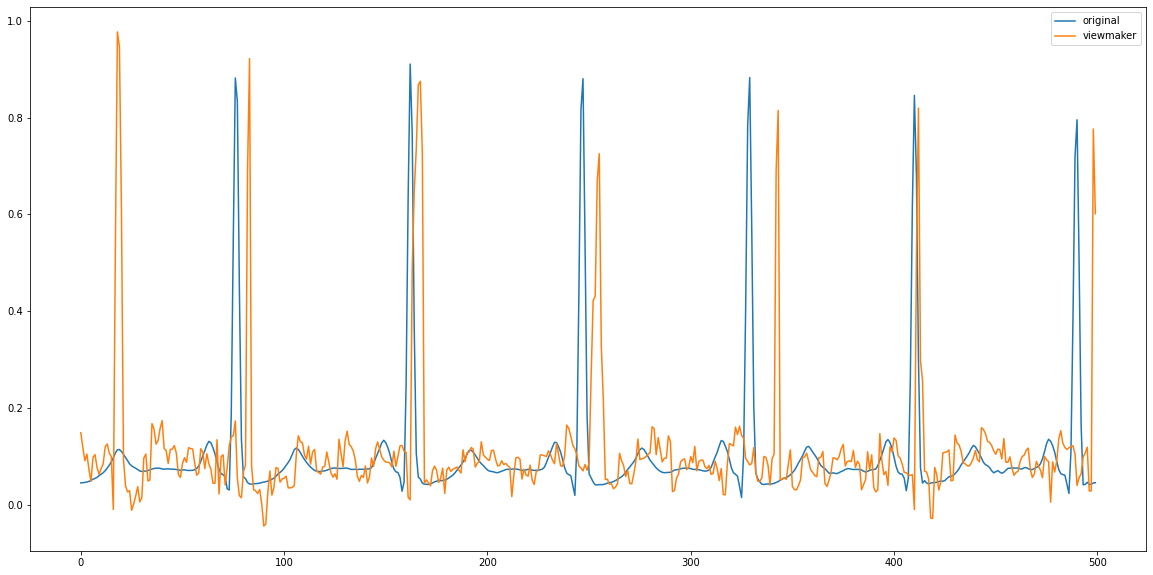

In [129]:
plt.figure(figsize=(20,10))
plt.plot(normalization(ecg_sample)[0,0,:500], label='original')
plt.plot(aug_ecg.detach().numpy()[0,0, :500], label='viewmaker')
plt.legend()

In [23]:
aug_params = np.load('/home/hy29/rdf/viewmaker_physiological/experiments/sleep_apnea/init_run/params_dict.npy', allow_pickle=True).item()

In [122]:
jitter_sigma, scaling_sigma, rotation_prob, mixture_weights, nromal_mean, nromal_sigma, permuation_seg, magW_sigma = aug_params[5]

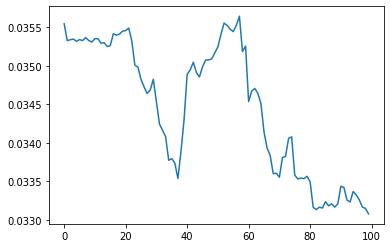

In [130]:
plt.plot([0.05 * sigmoid(aug_params[i][2]) for i in range(100)])